In [57]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [59]:
df = pd.read_csv("../data/processed/datasets/oa_averages_closed_zed.csv")


In [70]:
df.head()

,low stability,AP MAD,AP Max abs dev,AP Range,AP Variance,Ellipse area,ML MAD,ML Max abs dev,ML Range,ML Variance,Path length,Sway RMS
0,0,0.477583,1.915137,3.486096,0.376368,6.351870,0.453337,1.524755,2.553540,0.318798,68.956887,0.827851
1,0,0.678276,2.495103,4.335525,0.730022,10.981837,0.532944,2.504434,4.052350,0.525139,70.043686,1.115015
2,0,0.416209,1.494899,2.642785,0.275269,2.199867,0.189622,0.785057,1.364758,0.059327,65.094409,0.572380
3,0,0.523784,1.807057,3.076013,0.440424,6.307854,0.441627,1.648543,2.738688,0.388845,90.101066,0.858346
4,0,0.894796,2.814422,4.881227,1.324788,13.272652,0.587390,1.865987,3.168333,0.533550,87.133700,1.337204


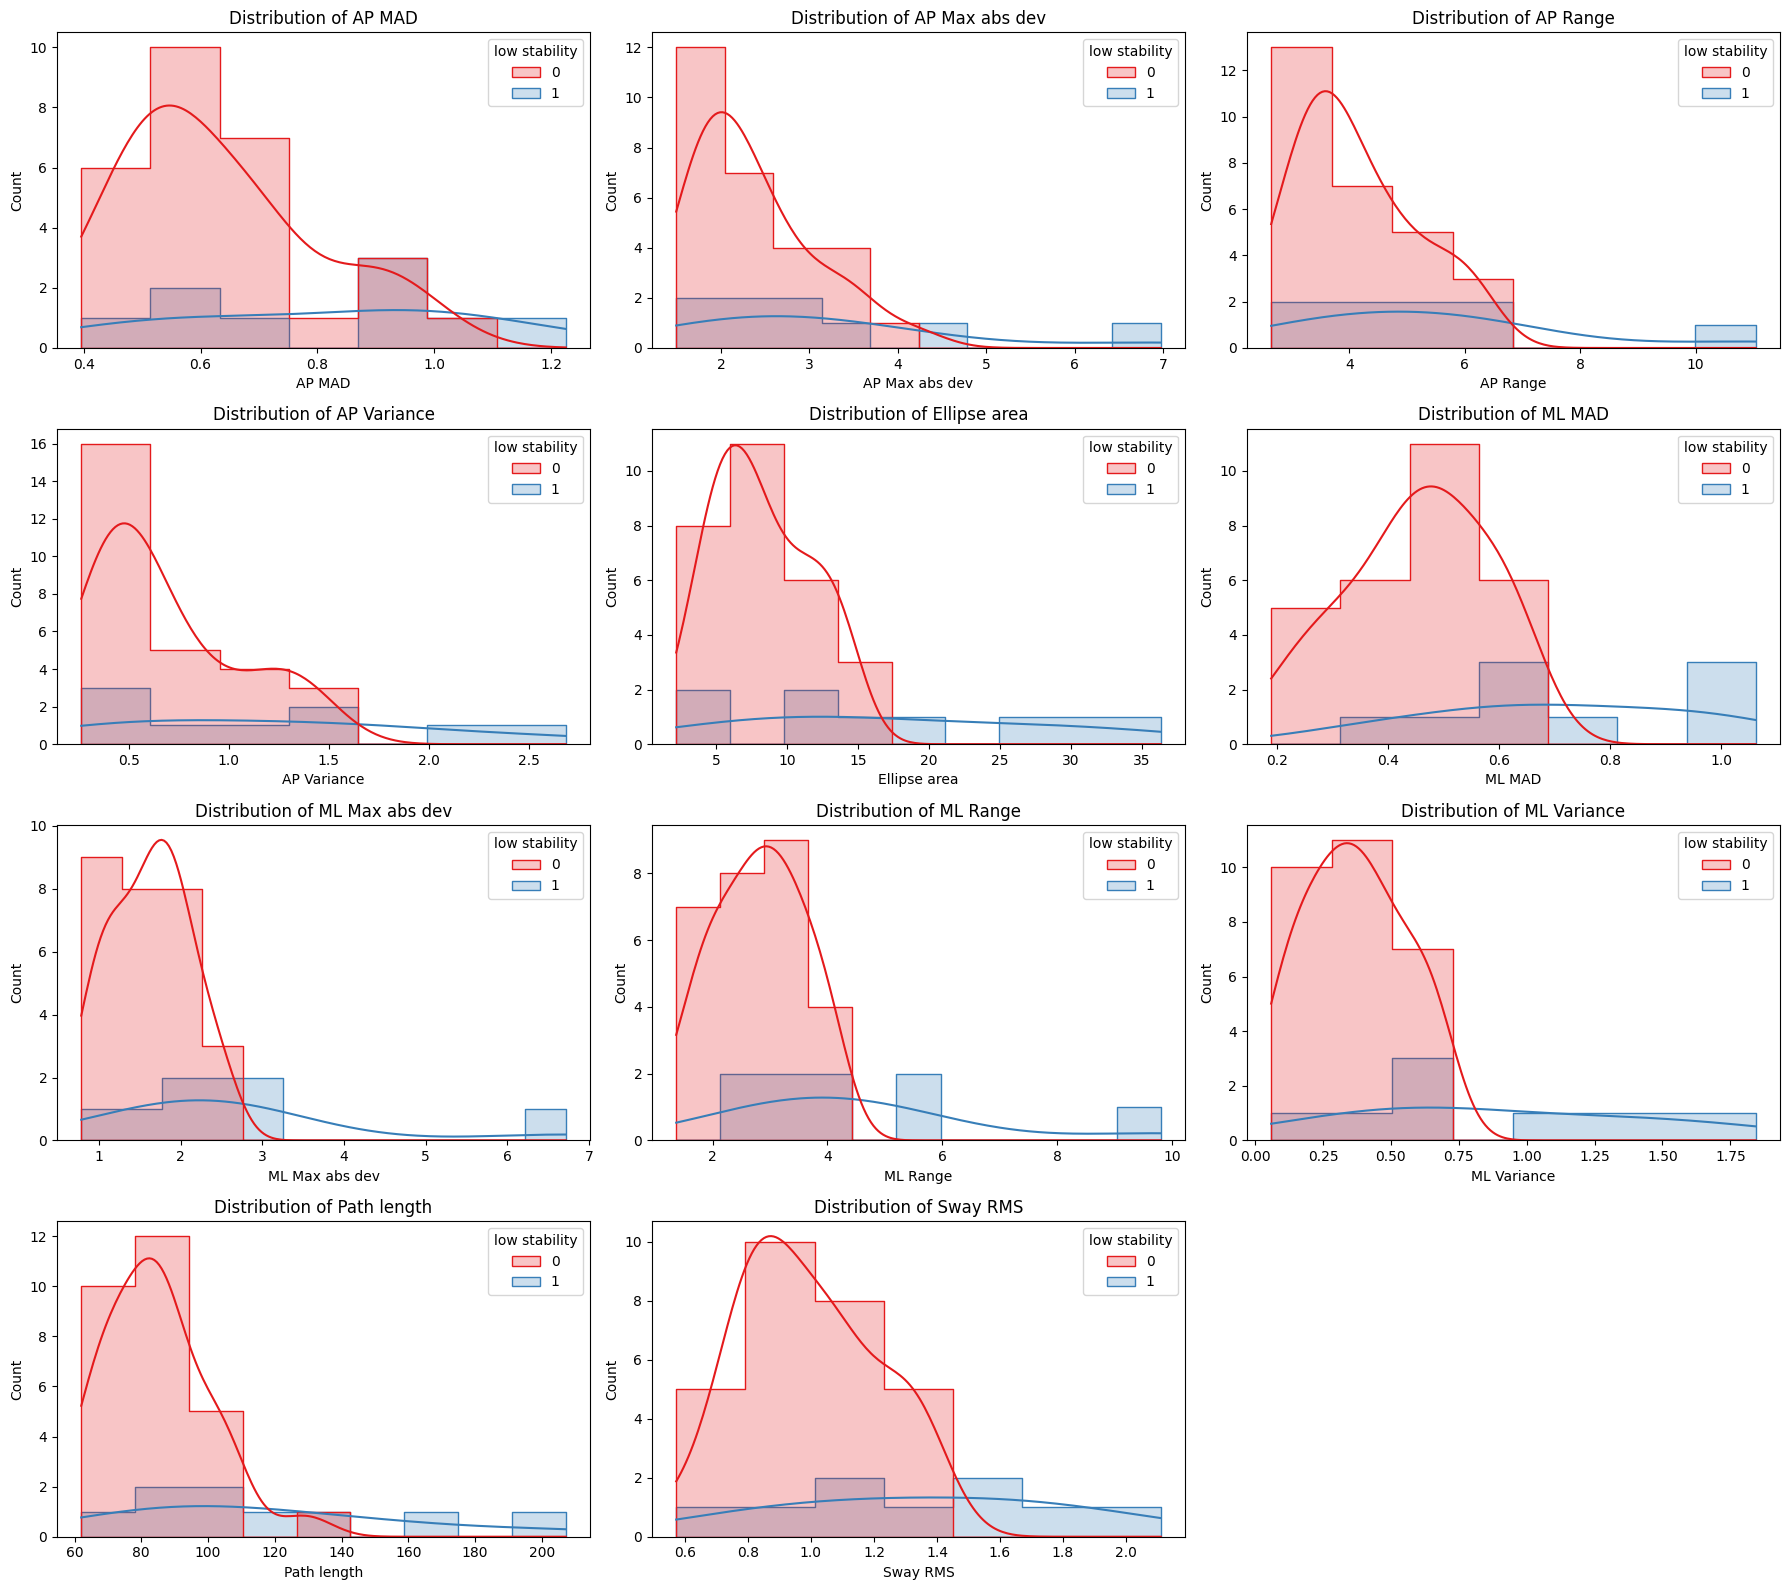

In [61]:
# Exclude target column
feature_columns = df.columns.drop('low stability')

# Set up subplots
n_cols = 3
n_rows = -(-len(feature_columns) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(feature_columns):
    sns.histplot(
        data=df,
        x=feature,
        hue='low stability',
        kde=True,
        element='step',
        palette='Set1',
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

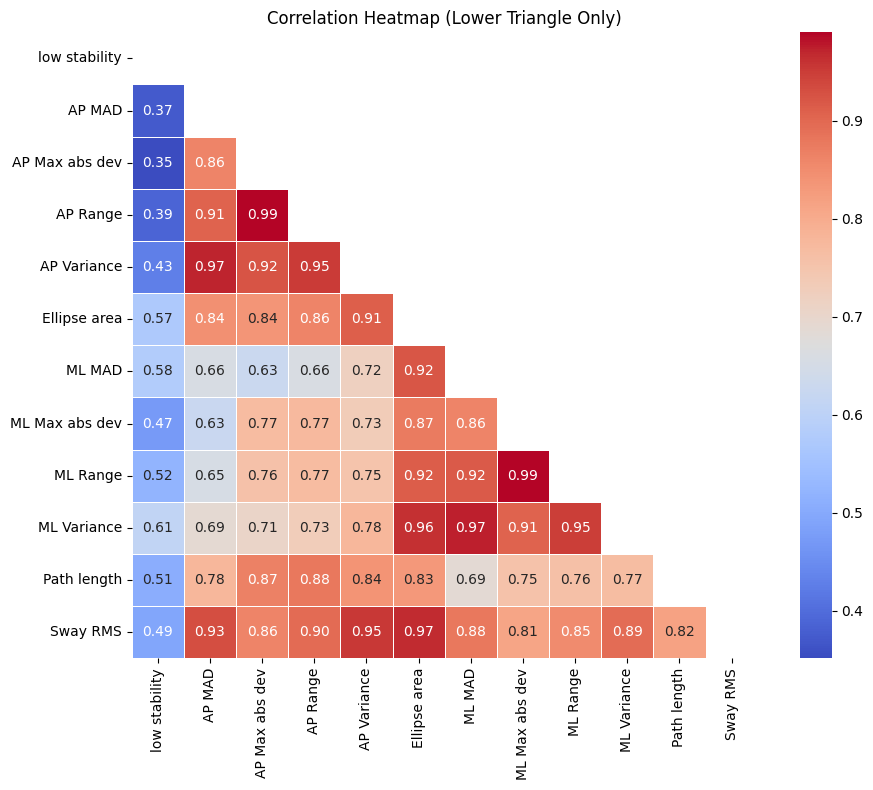

In [62]:
# Select numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap (Lower Triangle Only)")
plt.tight_layout()
plt.show()

## Fitting a model

In [63]:
# Define features and target
X = df.drop(columns=['low stability'])
y = df['low stability']

In [64]:
# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

In [65]:
# Initialize Leave-One-Out CV
loo = LeaveOneOut()

# Store predictions
y_true = []
y_pred = []

# Perform LOOCV
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Perform hyperparameter tuning within the training set
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    # Best model prediction
    best_model = grid.best_estimator_
    prediction = best_model.predict(X_test)

    # Store results
    y_true.append(y_test.values[0])
    y_pred.append(prediction[0])

In [66]:
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}


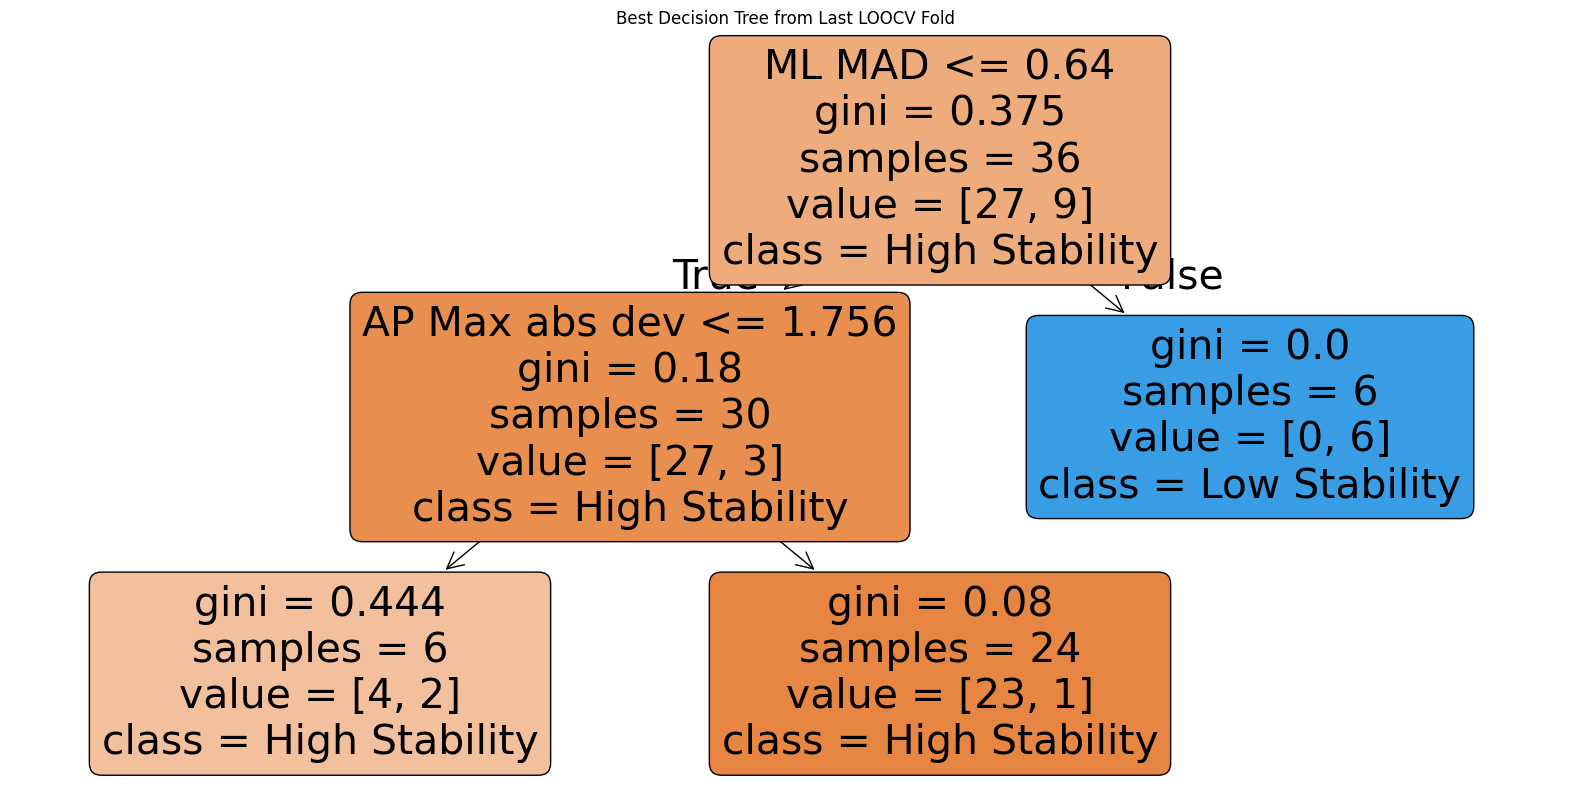

In [67]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X.columns,
    class_names=["High Stability", "Low Stability"],  # adjust if needed
    filled=True,
    rounded=True
)
plt.title("Best Decision Tree from Last LOOCV Fold")
plt.show()

In [ ]:
print("LOOCV Evaluation Metrics (with inner tuning):")
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, zero_division=0))
print("Recall: ", recall_score(y_true, y_pred, zero_division=0))
print("F1 Score: ", f1_score(y_true, y_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

LOOCV Evaluation Metrics (with inner tuning):
Accuracy:  0.918918918918919
Precision:  1.0
Recall:  0.6666666666666666
F1 Score:  0.8
Confusion Matrix:
[[28  0]
 [ 3  6]]
